In [ ]:
import pandas as pd
import numpy as np

INPUT_DAYS = 365  # 1 year history
FORECAST_DAYS = 7  # how many future days to predict
FEATURES = 6       # PM2.5, PM10, O3, NO2, SO2, AQI

# Load data and scale
df = pd.read_csv("daily_averages.csv")
data = df.drop(columns=["Date"]).astype(float).dropna()

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

X, y = [], []
for i in range(INPUT_DAYS, len(data_scaled) - FORECAST_DAYS + 1):
    X.append(data_scaled[i-INPUT_DAYS:i])              # shape (365, 6)
    y.append(data_scaled[i:i+FORECAST_DAYS])           # shape (N, 6)

X = np.array(X)  # shape: (samples, 365, 6)
y = np.array(y)  # shape: (samples, N, 6)

# Split into train/val
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

import torch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)


(9465, 6)


In [8]:
import torch.nn as nn

class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_days):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_days * input_size)

    def forward(self, x):
        # x: (batch, 365, 6)
        out, _ = self.lstm(x)                   # out: (batch, 365, hidden)
        out = out[:, -1, :]                     # Take last time step output: (batch, hidden)
        out = self.fc(out)                      # (batch, 7*6)
        out = out.view(-1, 7, 6)                # (batch, 7, 6)
        return out


In [11]:
model = LSTMPredictor(input_size=6, hidden_size=64, num_layers=2, output_days=7).to('cuda' if torch.cuda.is_available() else 'cpu')

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move data to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)


In [13]:
EPOCHS = 3

for epoch in range(1, EPOCHS + 1):
    model.train()
    optimizer.zero_grad()

    pred = model(X_train)
    loss = criterion(pred, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)
        val_loss = criterion(val_pred, y_val)

    print(f"Epoch {epoch}/{EPOCHS} - Train Loss: {loss.item():.6f} - Val Loss: {val_loss.item():.6f}")


Epoch 1/3 - Train Loss: 0.106675 - Val Loss: 0.079492
Epoch 2/3 - Train Loss: 0.103345 - Val Loss: 0.076695
Epoch 3/3 - Train Loss: 0.100029 - Val Loss: 0.073856


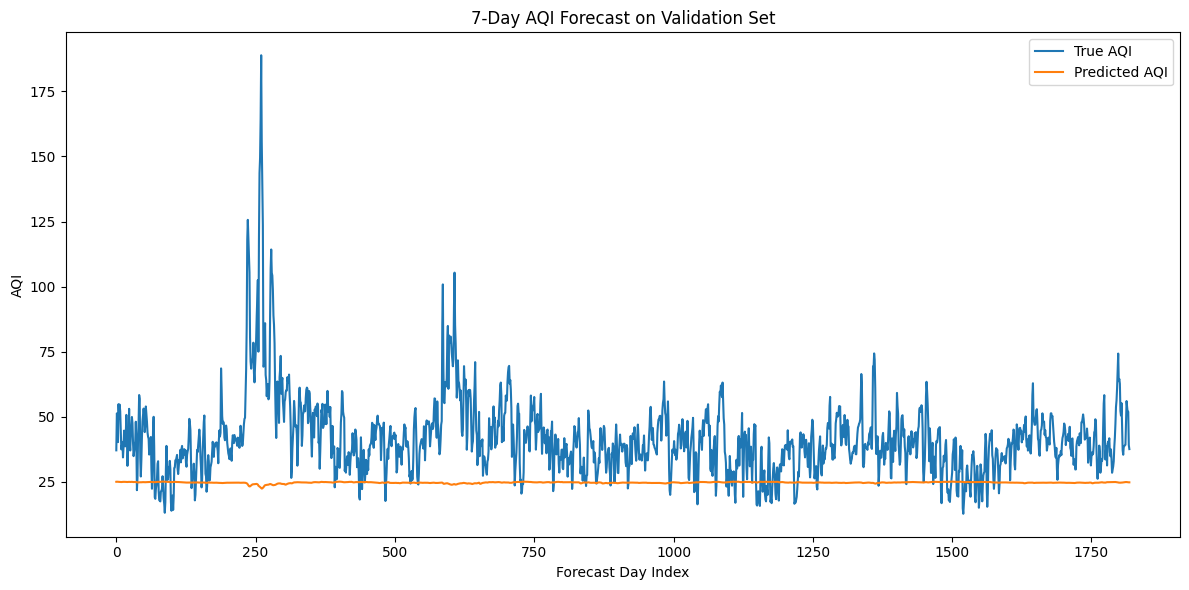

In [15]:
# Move to CPU for plotting
val_pred_np = val_pred.detach().cpu().numpy()
y_val_np = y_val.detach().cpu().numpy()

# Inverse scale AQI (assume AQI is column 5)
from sklearn.preprocessing import MinMaxScaler

aqi_index = 5
aqi_pred = []
aqi_true = []

for i in range(len(val_pred_np)):
    for j in range(1):  # 7 forecast days
        # Create dummy row to inverse-transform only AQI
        row = np.zeros((6,))
        row[aqi_index] = val_pred_np[i, j, aqi_index]
        aqi_pred.append(scaler.inverse_transform([row])[0][aqi_index])

        row[aqi_index] = y_val_np[i, j, aqi_index]
        aqi_true.append(scaler.inverse_transform([row])[0][aqi_index])

# Plot AQI predictions vs true
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(aqi_true, label="True AQI")
plt.plot(aqi_pred, label="Predicted AQI")
plt.title("7-Day AQI Forecast on Validation Set")
plt.xlabel("Forecast Day Index")
plt.ylabel("AQI")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
################################################################################################################################################################################################################################################

In [1]:
import pandas as pd
import numpy as np
import torch, torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Hyperparams
INPUT_DAYS = 365
OUTPUT_DAYS = 7
FEATURES = 6
HIDDEN = 64
LAYERS = 2
DROPOUT = 0.3
LR = 1e-3
EPOCHS = 20
CLIP = 1.0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
FEATURE_NAMES = ["PM2.5", "PM10", "O3", "NO2", "SO2", "AQI"]


In [2]:
df = pd.read_csv("daily_averages.csv", parse_dates=["Date"])
df = df.set_index("Date").sort_index()

# Ensure continuous daily index
all_dates = pd.date_range(df.index.min(), df.index.max(), freq='D')
df = df.reindex(all_dates)

# Drop Feb 29
mask_feb29 = (df.index.month==2)&(df.index.day==29)
df = df.loc[~mask_feb29]

# Fill missing values
df = df.interpolate(method="time").fillna(method="bfill").fillna(method="ffill")

# Optional smoothing: rolling mean (3-day)
df_smooth = df.rolling(3, min_periods=1, center=True).mean()

# Prepare data matrix
data = df_smooth.to_numpy()  # shape: (days, 6)

# Standardize
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)


/var/folders/pw/x_mxyr4s2w3214m_n7jx1y2w0000gn/T/ipykernel_40687/4225749261.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.interpolate(method="time").fillna(method="bfill").fillna(method="ffill")


In [3]:
X, y = [], []
for i in range(INPUT_DAYS, len(data_scaled) - OUTPUT_DAYS + 1):
    X.append(data_scaled[i-INPUT_DAYS:i])
    y.append(data_scaled[i:i+OUTPUT_DAYS])
X = np.array(X)
y = np.array(y)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=False)

X_train = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
y_train = torch.tensor(y_train, dtype=torch.float32).to(DEVICE)
X_val = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
y_val = torch.tensor(y_val, dtype=torch.float32).to(DEVICE)


In [4]:
class LSTMPredictor(nn.Module):
    def __init__(self, inp, hid, layers, out_days, feat, dropout):
        super().__init__()
        self.lstm = nn.LSTM(inp, hid, layers, batch_first=True, dropout=dropout)
        self.norm = nn.LayerNorm(hid)
        self.fc = nn.Linear(hid, out_days * feat)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        h = self.norm(out[:, -1, :])
        return self.fc(h).view(-1, OUTPUT_DAYS, FEATURES)

model = LSTMPredictor(FEATURES, HIDDEN, LAYERS, OUTPUT_DAYS, FEATURES, DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.L1Loss()


In [5]:
best_val = float('inf')
best_model = None

for epoch in range(1, EPOCHS+1):
    model.train()
    optimizer.zero_grad()
    pred = model(X_train)
    loss = criterion(pred, y_train)
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), CLIP)
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)
        val_loss = criterion(val_pred, y_val)
    
    print(f"Epoch {epoch}/{EPOCHS} Train: {loss:.4f} Val: {val_loss:.4f}")
    if val_loss < best_val:
        best_val = val_loss
        best_model = model.state_dict()


Epoch 1/20 Train: 0.8884 Val: 0.8184
Epoch 2/20 Train: 0.8418 Val: 0.7842
Epoch 3/20 Train: 0.8006 Val: 0.7552
Epoch 4/20 Train: 0.7642 Val: 0.7308
Epoch 5/20 Train: 0.7335 Val: 0.7102
Epoch 6/20 Train: 0.7077 Val: 0.6926
Epoch 7/20 Train: 0.6861 Val: 0.6771
Epoch 8/20 Train: 0.6684 Val: 0.6629
Epoch 9/20 Train: 0.6534 Val: 0.6498
Epoch 10/20 Train: 0.6405 Val: 0.6375
Epoch 11/20 Train: 0.6295 Val: 0.6261
Epoch 12/20 Train: 0.6198 Val: 0.6155
Epoch 13/20 Train: 0.6112 Val: 0.6054
Epoch 14/20 Train: 0.6040 Val: 0.5956
Epoch 15/20 Train: 0.5962 Val: 0.5858
Epoch 16/20 Train: 0.5899 Val: 0.5761
Epoch 17/20 Train: 0.5833 Val: 0.5666
Epoch 18/20 Train: 0.5767 Val: 0.5574
Epoch 19/20 Train: 0.5705 Val: 0.5486
Epoch 20/20 Train: 0.5644 Val: 0.5402


In [6]:
torch.save(best_model,"best_pollution_lstm.pth")
print("Best model saved with val loss:", best_val)

Best model saved with val loss: tensor(0.5402)


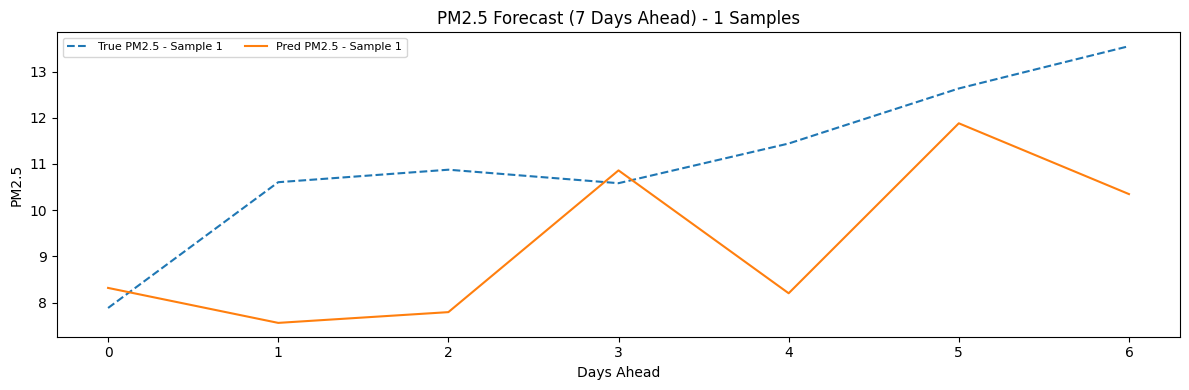

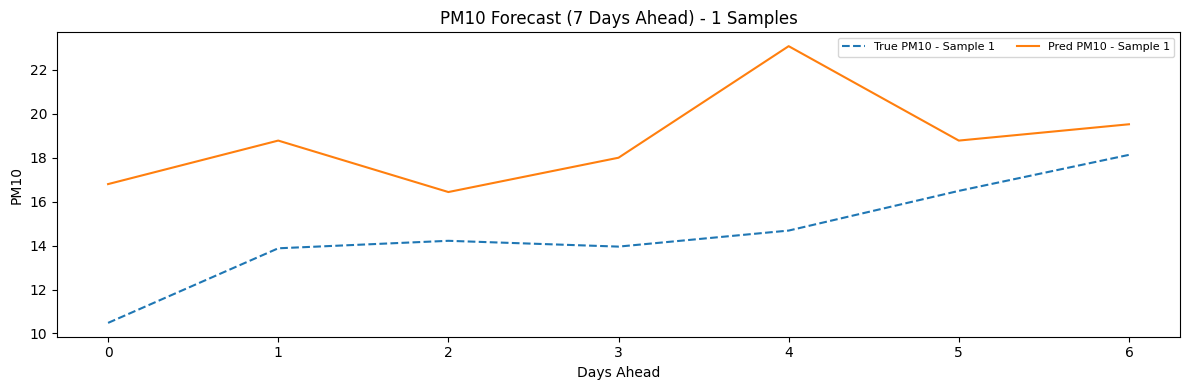

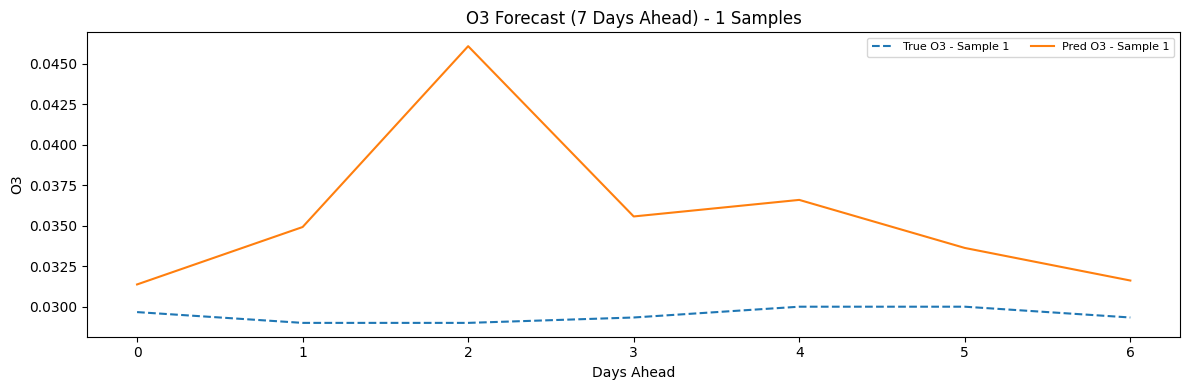

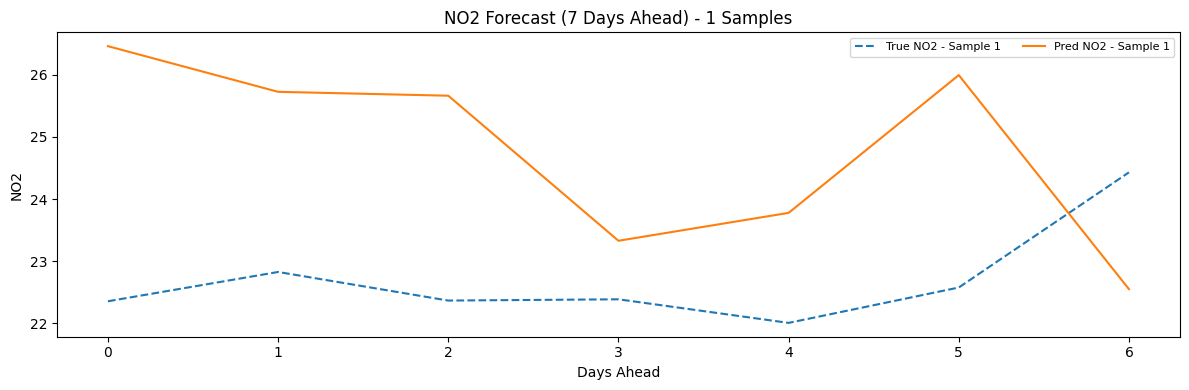

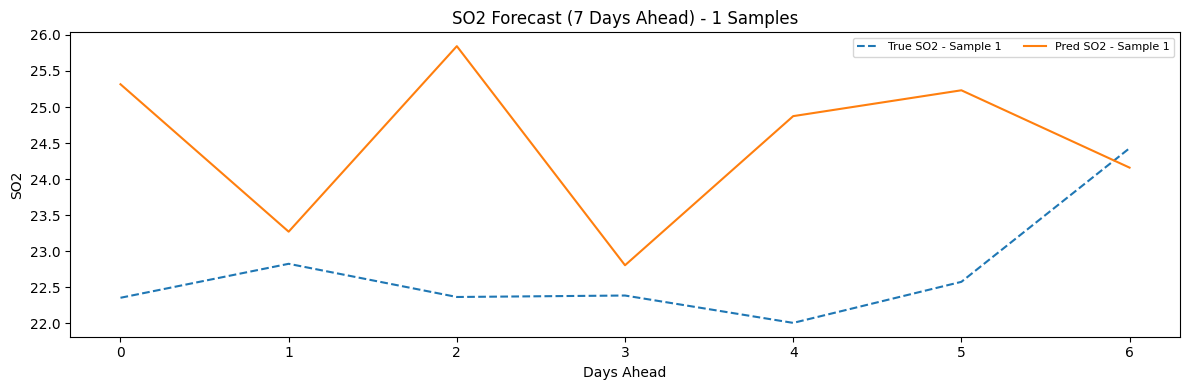

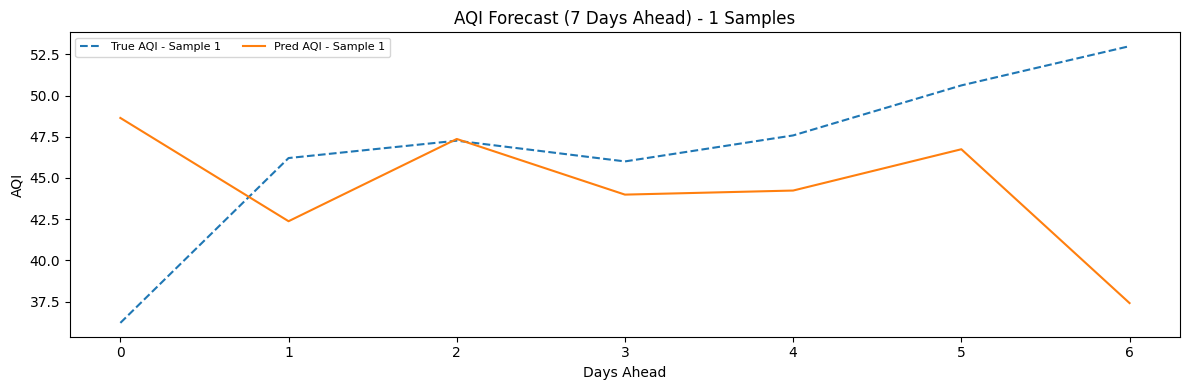

In [9]:
# Ensure predictions and ground truth are on the original scale
val_pred_np = val_pred.cpu().numpy()
y_val_np = y_val.cpu().numpy()

val_pred_real = scaler.inverse_transform(val_pred_np.reshape(-1, FEATURES)).reshape(-1, OUTPUT_DAYS, FEATURES)
y_val_real = scaler.inverse_transform(y_val_np.reshape(-1, FEATURES)).reshape(-1, OUTPUT_DAYS, FEATURES)

# Plot settings
n_samples = 1
time_axis = list(range(OUTPUT_DAYS))

for feat_idx, feat_name in enumerate(FEATURE_NAMES):
    plt.figure(figsize=(12, 4))
    
    for i in range(n_samples):
        plt.plot(time_axis, y_val_real[i, :, feat_idx], label=f"True {feat_name} - Sample {i+1}", linestyle='--')
        plt.plot(time_axis, val_pred_real[i, :, feat_idx], label=f"Pred {feat_name} - Sample {i+1}")
    
    plt.title(f"{feat_name} Forecast ({OUTPUT_DAYS} Days Ahead) - {n_samples} Samples")
    plt.xlabel("Days Ahead")
    plt.ylabel(feat_name)
    plt.legend(ncol=2, fontsize=8)
    plt.tight_layout()
    plt.show()


7-Day Pollution Forecast (based on last 30 days):
                PM2.5       PM10        O3        NO2        SO2        AQI
2025-01-01   8.991338  17.551903  0.032631  26.070484  25.961874  50.724316
2025-01-02   8.776334  19.927891  0.034213  24.925201  24.167896  43.464127
2025-01-03   8.780435  17.245680  0.047069  26.060509  26.762508  48.177227
2025-01-04  11.331729  19.658207  0.035129  24.507183  24.490755  47.283096
2025-01-05   9.054685  23.762119  0.037353  24.671555  25.726343  46.051636
2025-01-06  12.645150  19.095879  0.033013  27.013123  25.112572  47.604580
2025-01-07  10.766526  20.517010  0.033262  23.242113  24.917479  39.743107


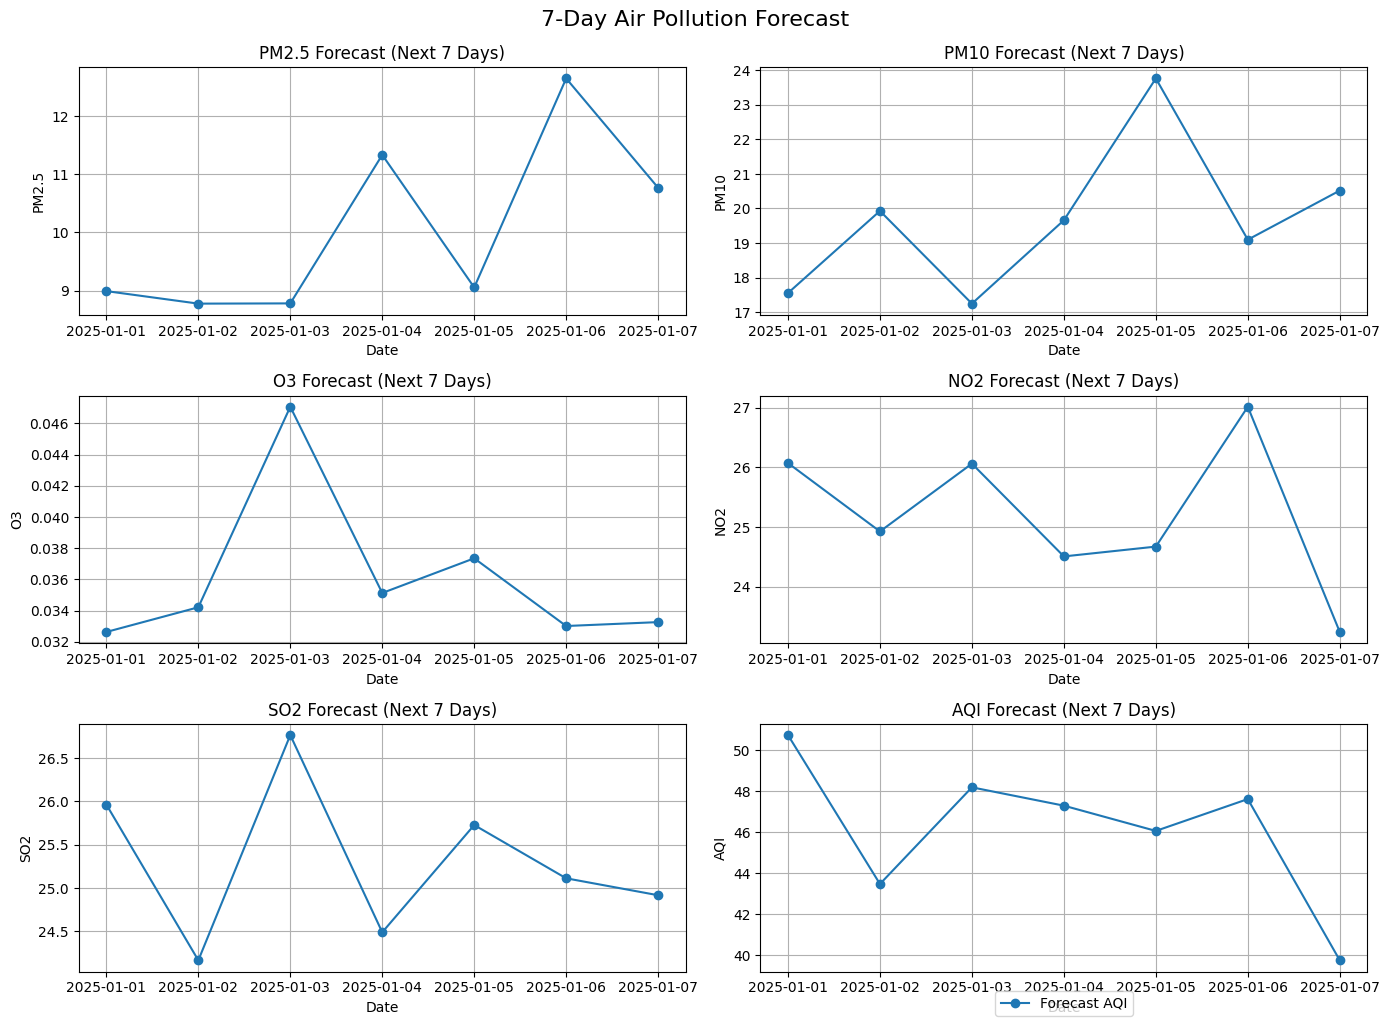

In [12]:
# --- Testing: Predict next 7 days using past 30 days (no reuse of training variables) ---
TEST_INPUT_DAYS = 30
TEST_OUTPUT_DAYS = 7

# Prepare test input: last 30 days
test_recent_data = df_smooth[-TEST_INPUT_DAYS:].to_numpy()  # shape: (30, FEATURES)
test_scaled = scaler.transform(test_recent_data)  # shape: (30, FEATURES)
test_input = torch.tensor(test_scaled, dtype=torch.float32).unsqueeze(0).to(DEVICE)  # shape: (1, 30, FEATURES)

# Load model structure and weights
test_model = LSTMPredictor(FEATURES, HIDDEN, LAYERS, TEST_OUTPUT_DAYS, FEATURES, DROPOUT).to(DEVICE)
test_model.load_state_dict(torch.load("best_pollution_lstm.pth"))
test_model.eval()

# Predict
with torch.no_grad():
    test_output = test_model(test_input).cpu().numpy()  # shape: (1, 7, FEATURES)

# Inverse transform to original scale
test_output_real = scaler.inverse_transform(test_output.reshape(-1, FEATURES)).reshape(TEST_OUTPUT_DAYS, FEATURES)

# Create DataFrame with future dates
test_future_dates = pd.date_range(df_smooth.index[-1] + pd.Timedelta(days=1), periods=TEST_OUTPUT_DAYS)
test_predictions_df = pd.DataFrame(test_output_real, index=test_future_dates, columns=FEATURE_NAMES)

# Show predictions
print("7-Day Pollution Forecast (based on last 30 days):")
print(test_predictions_df)

import matplotlib.pyplot as plt

# Plot forecast
plt.figure(figsize=(14, 10))

for i, feature in enumerate(FEATURE_NAMES):
    plt.subplot(3, 2, i + 1)
    plt.plot(test_predictions_df.index, test_predictions_df[feature], marker='o', label=f"Forecast {feature}")
    plt.title(f"{feature} Forecast (Next 7 Days)")
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.grid(True)
    plt.tight_layout()

plt.suptitle("7-Day Air Pollution Forecast", fontsize=16, y=1.02)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=3)
plt.show()



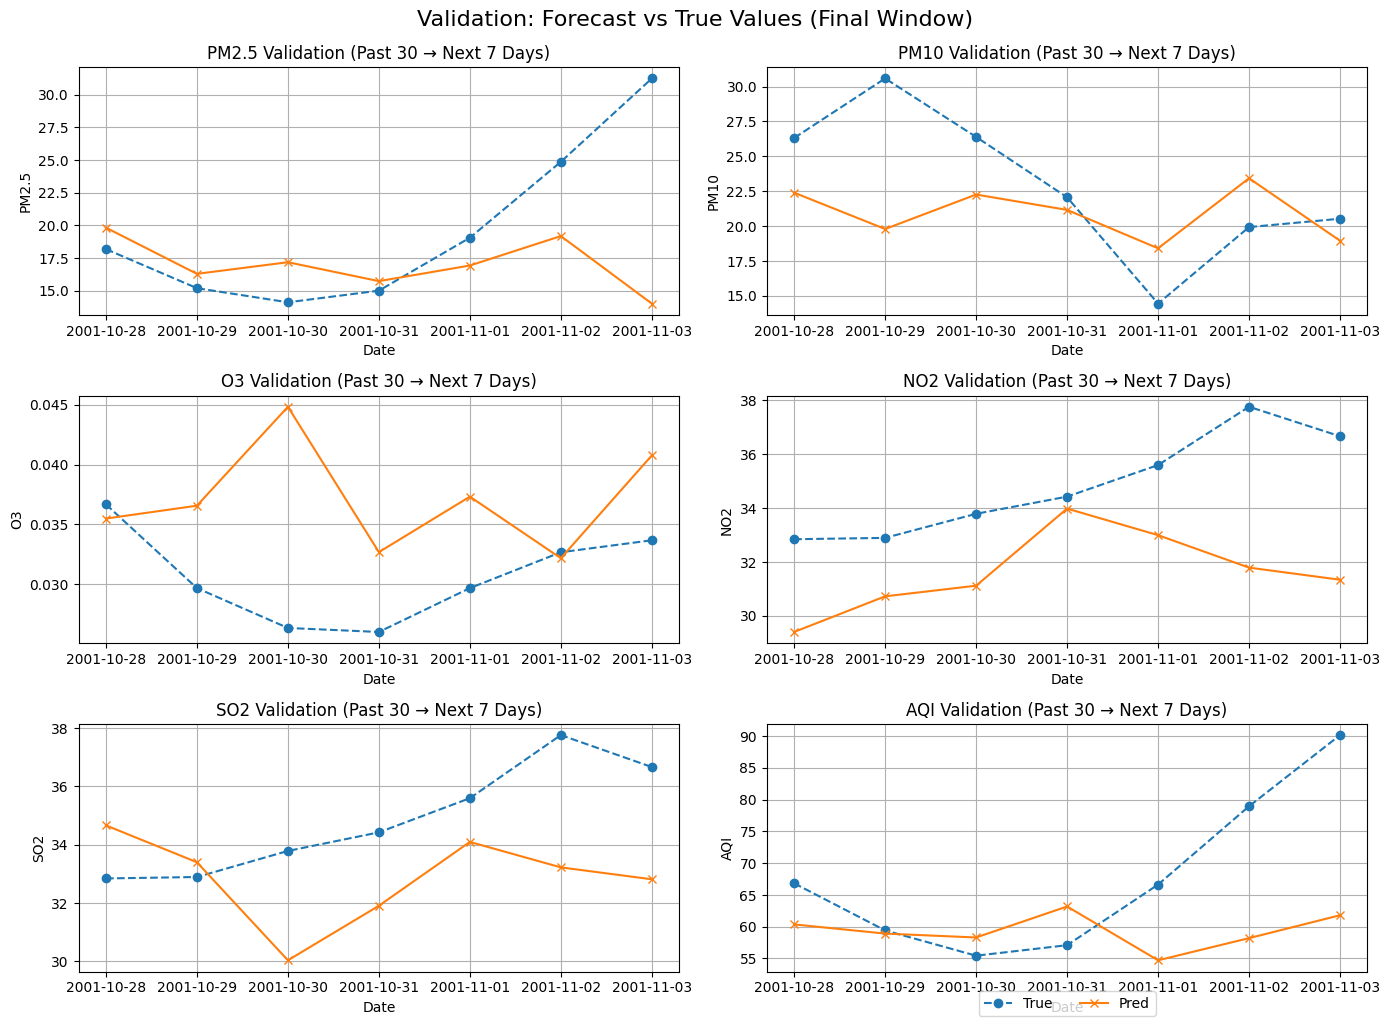

In [16]:
# --- Validation Run: Compare prediction vs actual future values ---
VAL_INPUT_DAYS = 30
VAL_OUTPUT_DAYS = 7

# Ensure there are at least 30 + 7 days at the end of the dataset
if len(df_smooth) < VAL_INPUT_DAYS + VAL_OUTPUT_DAYS:
    raise ValueError("Not enough data for validation slice.")

# Choose a valid midpoint for validation
val_midpoint = 1000  # pick a day safely away from both edges of the dataset

# Define window indices
val_input_data = df_smooth[val_midpoint : val_midpoint + VAL_INPUT_DAYS].to_numpy()
val_target_data = df_smooth[val_midpoint + VAL_INPUT_DAYS : val_midpoint + VAL_INPUT_DAYS + VAL_OUTPUT_DAYS].to_numpy()

# Normalize input
val_input_scaled = scaler.transform(val_input_data)
val_input_tensor = torch.tensor(val_input_scaled, dtype=torch.float32).unsqueeze(0).to(DEVICE)

# Load model
val_model = LSTMPredictor(FEATURES, HIDDEN, LAYERS, VAL_OUTPUT_DAYS, FEATURES, DROPOUT).to(DEVICE)
val_model.load_state_dict(torch.load("best_pollution_lstm.pth"))
val_model.eval()

# Predict
with torch.no_grad():
    val_pred_scaled = val_model(val_input_tensor).cpu().numpy()

# Inverse transform predictions and ground truth
val_pred_real = scaler.inverse_transform(val_pred_scaled.reshape(-1, FEATURES)).reshape(VAL_OUTPUT_DAYS, FEATURES)
val_target_real = val_target_data  # Already in real scale


# Corresponding dates
val_dates = df_smooth.index[val_midpoint + VAL_INPUT_DAYS : val_midpoint + VAL_INPUT_DAYS + VAL_OUTPUT_DAYS]

# Plot comparison
plt.figure(figsize=(14, 10))
for i, feature in enumerate(FEATURE_NAMES):
    plt.subplot(3, 2, i + 1)
    plt.plot(val_dates, val_target_real[:, i], label="True", marker='o', linestyle='--')
    plt.plot(val_dates, val_pred_real[:, i], label="Pred", marker='x')
    plt.title(f"{feature} Validation (Past 30 → Next 7 Days)")
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.grid(True)
    plt.tight_layout()

plt.suptitle("Validation: Forecast vs True Values (Final Window)", fontsize=16, y=1.02)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.show()


In [22]:
# Compute errors for your model's predictions (val_pred_real vs val_target_real)
mae_model = {}
rmse_model = {}

for i, feature in enumerate(FEATURE_NAMES):
    y_true = val_target_real[:, i]
    y_pred = val_pred_real[:, i]
    mae_model[feature] = mean_absolute_error(y_true, y_pred)
    rmse_model[feature] = np.sqrt(mean_squared_error(y_true, y_pred))

print("Model Errors:")
print("-" * 40)
print("{:<10} {:>10} {:>10}".format("Feature", "MAE", "RMSE"))
print("-" * 40)
for feature in FEATURE_NAMES:
    print(f"{feature:<10} {mae_model[feature]:>10.3f} {rmse_model[feature]:>10.3f}")

avg_mae_model = np.mean(list(mae_model.values()))
avg_rmse_model = np.mean(list(rmse_model.values()))
print("-" * 40)
print(f"{'Average':<10} {avg_mae_model:>10.3f} {avg_rmse_model:>10.3f}")

Model Errors:
----------------------------------------
Feature           MAE       RMSE
----------------------------------------
PM2.5           4.510      7.045
PM10            4.115      5.077
O3              0.007      0.009
NO2             3.230      3.675
SO2             2.639      2.965
AQI            10.992     14.461
----------------------------------------
Average         4.249      5.539


In [20]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Naive forecast: repeat last day of input for all 7 output days
naive_forecast = np.tile(val_input_data[-1], (VAL_OUTPUT_DAYS, 1))  # shape: (7, FEATURES)

# Compute errors vs true next 7 days (val_target_data)
mae_naive = {}
rmse_naive = {}

for i, feature in enumerate(FEATURE_NAMES):
    y_true = val_target_data[:, i]
    y_pred = naive_forecast[:, i]
    mae_naive[feature] = mean_absolute_error(y_true, y_pred)
    rmse_naive[feature] = np.sqrt(mean_squared_error(y_true, y_pred))

print("Naive Baseline Errors:")
print("-" * 40)
print("{:<10} {:>10} {:>10}".format("Feature", "MAE", "RMSE"))
print("-" * 40)
for feature in FEATURE_NAMES:
    print(f"{feature:<10} {mae_naive[feature]:>10.3f} {rmse_naive[feature]:>10.3f}")

avg_mae_naive = np.mean(list(mae_naive.values()))
avg_rmse_naive = np.mean(list(rmse_naive.values()))
print("-" * 40)
print(f"{'Average':<10} {avg_mae_naive:>10.3f} {avg_rmse_naive:>10.3f}")


Naive Baseline Errors:
----------------------------------------
Feature           MAE       RMSE
----------------------------------------
PM2.5           7.687      8.445
PM10            6.734      8.035
O3              0.013      0.013
NO2             4.981      5.280
SO2             4.981      5.280
AQI            16.574     18.466
----------------------------------------
Average         6.828      7.586
